# Batch UCB


In [1]:
# direct to proper path
import os
import sys
module_path = os.path.abspath(os.path.join('../../..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from collections import defaultdict
import math
import json

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import PairwiseKernel, DotProduct, RBF 
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import r2_score, mean_squared_error, make_scorer
from sklearn.model_selection import KFold
from sklearn_extra.cluster import KMedoids

from codes.embedding import Embedding
from codes.environment import Rewards_env
from codes.ucb import GPUCB, Random
from codes.evaluations import evaluate, plot_eva
from codes.regression import *
from codes.kernels_for_GPK import *
from codes.batch_ucb import *

from ipywidgets import IntProgress
from IPython.display import display
import warnings
%matplotlib inline

/home/admin-u6015325/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


/home/admin-u6015325/ownCloud/git/SynbioML/notebooks/rec_design/round3_design
['/home/admin-u6015325/ownCloud/git/SynbioML/notebooks/rec_design/round3_design', '/home/admin-u6015325/anaconda3/lib/python37.zip', '/home/admin-u6015325/anaconda3/lib/python3.7', '/home/admin-u6015325/anaconda3/lib/python3.7/lib-dynload', '', '/home/admin-u6015325/anaconda3/lib/python3.7/site-packages', '/home/admin-u6015325/anaconda3/lib/python3.7/site-packages/strkernel-0.2-py3.7.egg', '/home/admin-u6015325/anaconda3/lib/python3.7/site-packages/IPython/extensions', '/home/admin-u6015325/.ipython', '/home/admin-u6015325/ownCloud/git/SynbioML']


**Update 13/Nov/2020** Generate recommendation for round 2 (with partial replicates for round 0 and 1)

In [2]:
norm_method = 'mean'
log_flag = 'True'
Path = '../../../data/Results_Microplate_partialTrue_normTrue_' + norm_method+ '_roundRep_formatSeq_log' + log_flag + '.csv'

known_df = pd.read_csv(Path)
known_df.head()

,idx,RBS,Name,Rep1,Rep2,Rep3,Rep4,Rep5,Rep6,AVERAGE,...,Round,Rep7,Rep8,Rep9,Unnamed: 19,Unnamed: 20,RBS6,Pred Mean,Pred Std,Pred UCB
0,648.0,TTTAAGAAGGAGATATACAT,RBS_1by1_0,2.482263,2.555338,2.358414,3.102950,2.999178,2.316265,2.635735,...,0,NaN,NaN,NaN,NaN,NaN,AGGAGA,NaN,NaN,NaN
1,4096.0,CTTAAGAAGGAGATATACAT,RBS_1by1_1,1.592779,1.694296,1.798210,1.850738,2.381356,1.996343,1.885620,...,0,NaN,NaN,NaN,NaN,NaN,AGGAGA,NaN,NaN,NaN
2,4097.0,GTTAAGAAGGAGATATACAT,RBS_1by1_2,0.626302,0.774704,0.947196,0.418233,0.532036,0.733023,0.671916,...,0,NaN,NaN,NaN,NaN,NaN,AGGAGA,NaN,NaN,NaN
3,4098.0,ATTAAGAAGGAGATATACAT,RBS_1by1_3,1.696364,1.917735,1.568130,1.600853,1.803056,1.260720,1.641143,...,0,NaN,NaN,NaN,NaN,NaN,AGGAGA,NaN,NaN,NaN
4,4099.0,TCTAAGAAGGAGATATACAT,RBS_1by1_4,1.582321,2.118618,1.417531,2.014216,1.831391,2.186262,1.858390,...,0,NaN,NaN,NaN,NaN,NaN,AGGAGA,NaN,NaN,NaN


In [3]:
# known_df = known_df[known_df['Group'] != 'bps_noncore']
# known_df.reset_index(inplace=True, drop=True)
# known_df['RBS'] = known_df['RBS6']
# known_df

## Conclusion of pipeline

- Data pre-processing: run codes/data_generating.py
    - log transform 
    - z-score normalisation for each replicate (zero mean and unit variance)
- Kernel: codes/kernels_for_GPK.py
    - weighted degree kernel with shift
    - normalisation: centering; unit variance; normalisation over the whole (train + test) kernel
    - l = 6 (maximum substring length)
    - s = 1 (shift)
    - sigma0 = 1 (signal std)
- Regression: codes/regression.py
    - Gaussian Process Regression
    - train on samples (multi-label) from first round result, i.e. train shape:  (1055, 20)
    - predict on all design space (4 * 6) except known sequences, i.e. test shape:  (3961, 20)
    - alpha = 2
- Recommendation: codes/batch_ucb.py
    - batch UCB (GP-BUCB)
    - beta = 2
    - recommendation size = 90

In [4]:
rec_size = 90
l = 6
s = 1
beta = 0
alpha = 2
sigma_0 = 1
kernel_name = 'WD_Kernel_Shift'
embedding = 'label'
kernel_norm_flag = True
centering_flag = True
unit_norm_flag = True

# Top n recommendations

return seuqneces with top n ucb score. 

In [5]:
top_n = Top_n_ucb(known_df, kernel_name=kernel_name, l=l, s=s, sigma_0=sigma_0,
                 embedding=embedding, alpha=alpha, rec_size=rec_size, beta=beta, 
                 kernel_norm_flag=kernel_norm_flag, centering_flag = centering_flag, unit_norm_flag=unit_norm_flag)

In [35]:
top_known_AVERAGE = top_n.df_known.sort_values(['AVERAGE'], ascending = False).head(90)
top_known_AVERAGE

,RBS,RBS6,AVERAGE,STD,Group,variable,label,pred mean,pred std
0,TTTAAGAAGGAGATATACAT,AGGAGA,2.635735,0.334474,Reference,Rep1,2.482263,1.189414,0.166621
358,TTTAAGAAGGAGATATACAT,AGGAGA,2.635735,0.334474,Reference,Rep2,2.555338,1.189414,0.166621
1790,TTTAAGAAGGAGATATACAT,AGGAGA,2.635735,0.334474,Reference,Rep6,2.316265,1.189414,0.166621
1432,TTTAAGAAGGAGATATACAT,AGGAGA,2.635735,0.334474,Reference,Rep5,2.999178,1.189414,0.166621
716,TTTAAGAAGGAGATATACAT,AGGAGA,2.635735,0.334474,Reference,Rep3,2.358414,1.189414,0.166621
...,...,...,...,...,...,...,...,...,...
1435,ATTAAGAAGGAGATATACAT,AGGAGA,1.641143,0.226911,BPS-NC,Rep5,1.803056,1.336565,0.346506
361,ATTAAGAAGGAGATATACAT,AGGAGA,1.641143,0.226911,BPS-NC,Rep2,1.917735,1.336565,0.346506
1793,ATTAAGAAGGAGATATACAT,AGGAGA,1.641143,0.226911,BPS-NC,Rep6,1.260720,1.336565,0.346506
1077,ATTAAGAAGGAGATATACAT,AGGAGA,1.641143,0.226911,BPS-NC,Rep4,1.600853,1.336565,0.346506


In [6]:
top_n.df_train_test

,AVERAGE,Group,Name,PERC,Plate,Pred Mean,Pred Std,Pred UCB,RBS,RBS6,...,Rep7,Rep8,Rep9,Replicates,Round,STD,Unnamed: 19,Unnamed: 20,Usable,train_test
idx,,,,,,,,,,,,,,,,,,,,,
648.0,2.635735,Reference,RBS_1by1_0,0.282440,First_Plate,NaN,NaN,NaN,TTTAAGAAGGAGATATACAT,AGGAGA,...,NaN,NaN,NaN,"1,2,3,4,5,6",0.0,0.334474,NaN,NaN,Yes,Train
4096.0,1.885620,BPS-NC,RBS_1by1_1,0.285821,First_Plate,NaN,NaN,NaN,CTTAAGAAGGAGATATACAT,AGGAGA,...,NaN,NaN,NaN,"1,2,3,4,5,6",0.0,0.279010,NaN,NaN,Yes,Train
4097.0,0.671916,BPS-NC,RBS_1by1_2,0.370243,First_Plate,NaN,NaN,NaN,GTTAAGAAGGAGATATACAT,AGGAGA,...,NaN,NaN,NaN,"1,2,3,4,5,6",0.0,0.187660,NaN,NaN,Yes,Train
4098.0,1.641143,BPS-NC,RBS_1by1_3,0.313749,First_Plate,NaN,NaN,NaN,ATTAAGAAGGAGATATACAT,AGGAGA,...,NaN,NaN,NaN,"1,2,3,4,5,6",0.0,0.226911,NaN,NaN,Yes,Train
4099.0,1.858390,BPS-NC,RBS_1by1_4,0.216994,First_Plate,NaN,NaN,NaN,TCTAAGAAGGAGATATACAT,AGGAGA,...,NaN,NaN,NaN,"1,2,3,4,5,6",0.0,0.306855,NaN,NaN,Yes,Train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4091.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TTTAAGATTTTGTTATACAT,TTTTGT,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Test
4084.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TTTAAGATTTTCATATACAT,TTTTCA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Test
4086.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TTTAAGATTTTCGTATACAT,TTTTCG,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Test


In [7]:
top_n_rec_df = top_n.run_experiment()

X train shape:  (2147, 20)
X test shape:  (3783, 20)
create kernel instance
wds_l6_sigma0_1_s1_center_True_unitnorm_True
Load saved kernel matrix...
finish creating kernel instance
gp_reg fit
wds_l6_sigma0_1_s1_center_True_unitnorm_True
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_True_unitnorm_True
Load saved kernel matrix...
gp_reg pred
finish reg


In [8]:
top_n_rec_df

,RBS,RBS6,AVERAGE,pred mean,pred std,ucb,lcb
idx,,,,,,,
2729.0,TTTAAGAGGGGGCTATACAT,GGGGGC,NaN,1.051928,0.486657,1.051928,1.051928
2721.0,TTTAAGAGGGGACTATACAT,GGGGAC,NaN,1.017517,0.425958,1.017517,1.017517
162.0,TTTAAGAAAGGAGTATACAT,AAGGAG,NaN,0.989109,0.455473,0.989109,0.989109
3258.0,TTTAAGATAGTGGTATACAT,TAGTGG,NaN,0.985374,0.474414,0.985374,0.985374
2731.0,TTTAAGAGGGGGTTATACAT,GGGGGT,NaN,0.916163,0.353368,0.916163,0.916163
...,...,...,...,...,...,...,...
15.0,TTTAAGAAAAATTTATACAT,AAAATT,NaN,0.573114,0.638002,0.573114,0.573114
26.0,TTTAAGAAAACGGTATACAT,AAACGG,NaN,0.572254,0.644076,0.572254,0.572254
185.0,TTTAAGAAAGTGCTATACAT,AAGTGC,NaN,0.567468,0.583124,0.567468,0.567468


(array([  8.,  25.,  94., 252., 438., 709., 885., 783., 485., 104.]),
 array([0.35336821, 0.38860049, 0.42383278, 0.45906506, 0.49429735,
        0.52952963, 0.56476191, 0.5999942 , 0.63522648, 0.67045877,
        0.70569105]),
 <a list of 10 Patch objects>)

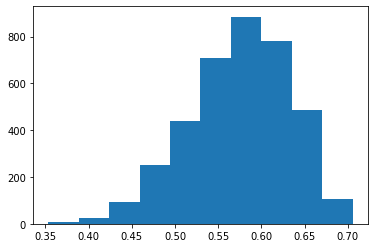

In [9]:
plt.hist(top_n.df_design['pred std'])

(array([ 4.,  3.,  8., 12., 19., 10.,  6., 15.,  6.,  7.]),
 array([0.35336821, 0.38609824, 0.41882828, 0.45155831, 0.48428835,
        0.51701838, 0.54974841, 0.58247845, 0.61520848, 0.64793852,
        0.68066855]),
 <a list of 10 Patch objects>)

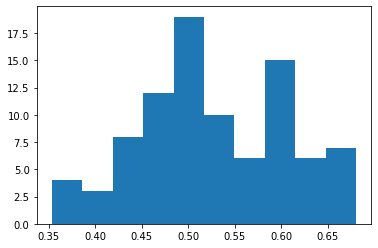

In [10]:
plt.hist(top_n_rec_df['pred std'])

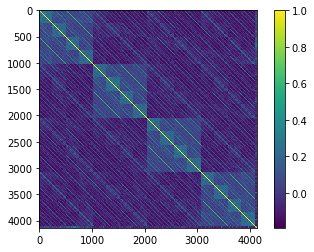

In [11]:
kernel_matrix = top_n.gpr.wd_kernel_instance.kernel_all_normalised
plt.imshow(kernel_matrix)
plt.colorbar()

## GP-BUCB

Desautels et al. 2014 Algorithm 2
http://jmlr.org/papers/volume15/desautels14a/desautels14a.pdf

In [12]:
gpbucb = GP_BUCB(known_df, kernel_name=kernel_name, l=l, s=s,sigma_0=sigma_0,
                 embedding=embedding, alpha=alpha, rec_size=rec_size, beta=beta, 
                 kernel_norm_flag=kernel_norm_flag, centering_flag = centering_flag, unit_norm_flag=unit_norm_flag)

In [13]:
gpbucb_rec_df = gpbucb.run_experiment()

X train shape:  (2147, 20)
X test shape:  (3783, 20)
create kernel instance
wds_l6_sigma0_1_s1_center_True_unitnorm_True
Load saved kernel matrix...
finish creating kernel instance
gp_reg fit
wds_l6_sigma0_1_s1_center_True_unitnorm_True
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_True_unitnorm_True
Load saved kernel matrix...
gp_reg pred
finish reg
train size  (359, 26)
X train shape:  (2148, 20)
X test shape:  (3782, 20)
create kernel instance
wds_l6_sigma0_1_s1_center_True_unitnorm_True
Load saved kernel matrix...
finish creating kernel instance
gp_reg fit
wds_l6_sigma0_1_s1_center_True_unitnorm_True
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_True_unitnorm_True
Load saved kernel matrix...
gp_reg pred
finish reg
train size  (360, 26)
X train shape:  (2149, 20)
X test shape:  (3781, 20)
create kernel instance
wds_l6_sigma0_1_s1_center_True_unitnorm_True
Load saved kernel matrix...
finish creating kernel instance
gp_reg fit
wds_l6_sigma0_1_s1_center_True_unitnorm_Tr

wds_l6_sigma0_1_s1_center_True_unitnorm_True
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_True_unitnorm_True
Load saved kernel matrix...
gp_reg pred
finish reg
train size  (380, 26)
X train shape:  (2169, 20)
X test shape:  (3761, 20)
create kernel instance
wds_l6_sigma0_1_s1_center_True_unitnorm_True
Load saved kernel matrix...
finish creating kernel instance
gp_reg fit
wds_l6_sigma0_1_s1_center_True_unitnorm_True
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_True_unitnorm_True
Load saved kernel matrix...
gp_reg pred
finish reg
train size  (381, 26)
X train shape:  (2170, 20)
X test shape:  (3760, 20)
create kernel instance
wds_l6_sigma0_1_s1_center_True_unitnorm_True
Load saved kernel matrix...
finish creating kernel instance
gp_reg fit
wds_l6_sigma0_1_s1_center_True_unitnorm_True
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_True_unitnorm_True
Load saved kernel matrix...
gp_reg pred
finish reg
train size  (382, 26)
X train shape:  (2171, 20)
X test shape:  (

finish reg
train size  (401, 26)
X train shape:  (2190, 20)
X test shape:  (3740, 20)
create kernel instance
wds_l6_sigma0_1_s1_center_True_unitnorm_True
Load saved kernel matrix...
finish creating kernel instance
gp_reg fit
wds_l6_sigma0_1_s1_center_True_unitnorm_True
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_True_unitnorm_True
Load saved kernel matrix...
gp_reg pred
finish reg
train size  (402, 26)
X train shape:  (2191, 20)
X test shape:  (3739, 20)
create kernel instance
wds_l6_sigma0_1_s1_center_True_unitnorm_True
Load saved kernel matrix...
finish creating kernel instance
gp_reg fit
wds_l6_sigma0_1_s1_center_True_unitnorm_True
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_True_unitnorm_True
Load saved kernel matrix...
gp_reg pred
finish reg
train size  (403, 26)
X train shape:  (2192, 20)
X test shape:  (3738, 20)
create kernel instance
wds_l6_sigma0_1_s1_center_True_unitnorm_True
Load saved kernel matrix...
finish creating kernel instance
gp_reg fit
wds_l6_si

wds_l6_sigma0_1_s1_center_True_unitnorm_True
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_True_unitnorm_True
Load saved kernel matrix...
gp_reg pred
finish reg
train size  (423, 26)
X train shape:  (2212, 20)
X test shape:  (3718, 20)
create kernel instance
wds_l6_sigma0_1_s1_center_True_unitnorm_True
Load saved kernel matrix...
finish creating kernel instance
gp_reg fit
wds_l6_sigma0_1_s1_center_True_unitnorm_True
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_True_unitnorm_True
Load saved kernel matrix...
gp_reg pred
finish reg
train size  (424, 26)
X train shape:  (2213, 20)
X test shape:  (3717, 20)
create kernel instance
wds_l6_sigma0_1_s1_center_True_unitnorm_True
Load saved kernel matrix...
finish creating kernel instance
gp_reg fit
wds_l6_sigma0_1_s1_center_True_unitnorm_True
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_True_unitnorm_True
Load saved kernel matrix...
gp_reg pred
finish reg
train size  (425, 26)
X train shape:  (2214, 20)
X test shape:  (

finish reg
train size  (444, 26)
X train shape:  (2233, 20)
X test shape:  (3697, 20)
create kernel instance
wds_l6_sigma0_1_s1_center_True_unitnorm_True
Load saved kernel matrix...
finish creating kernel instance
gp_reg fit
wds_l6_sigma0_1_s1_center_True_unitnorm_True
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_True_unitnorm_True
Load saved kernel matrix...
gp_reg pred
finish reg
train size  (445, 26)
X train shape:  (2234, 20)
X test shape:  (3696, 20)
create kernel instance
wds_l6_sigma0_1_s1_center_True_unitnorm_True
Load saved kernel matrix...
finish creating kernel instance
gp_reg fit
wds_l6_sigma0_1_s1_center_True_unitnorm_True
Load saved kernel matrix...
wds_l6_sigma0_1_s1_center_True_unitnorm_True
Load saved kernel matrix...
gp_reg pred
finish reg
train size  (446, 26)
X train shape:  (2235, 20)
X test shape:  (3695, 20)
create kernel instance
wds_l6_sigma0_1_s1_center_True_unitnorm_True
Load saved kernel matrix...
finish creating kernel instance
gp_reg fit
wds_l6_si

## Recommendation results

In [14]:
gpbucb_rec_df

,RBS,RBS6,AVERAGE,pred mean,pred std,ucb,lcb
idx,,,,,,,
2729.0,TTTAAGAGGGGGCTATACAT,GGGGGC,NaN,1.051928,0.486657,1.051928,1.051928
2721.0,TTTAAGAGGGGACTATACAT,GGGGAC,NaN,1.017517,0.425420,1.017517,1.017517
162.0,TTTAAGAAAGGAGTATACAT,AAGGAG,NaN,0.989109,0.455444,0.989109,0.989109
3258.0,TTTAAGATAGTGGTATACAT,TAGTGG,NaN,0.985374,0.474377,0.985374,0.985374
2731.0,TTTAAGAGGGGGTTATACAT,GGGGGT,NaN,0.916163,0.350266,0.916163,0.916163
...,...,...,...,...,...,...,...
15.0,TTTAAGAAAAATTTATACAT,AAAATT,NaN,0.573114,0.550503,0.573114,0.573114
26.0,TTTAAGAAAACGGTATACAT,AAACGG,NaN,0.572254,0.561592,0.572254,0.572254
185.0,TTTAAGAAAGTGCTATACAT,AAGTGC,NaN,0.567468,0.539113,0.567468,0.567468


In [15]:
top_n_rec_df

,RBS,RBS6,AVERAGE,pred mean,pred std,ucb,lcb
idx,,,,,,,
2729.0,TTTAAGAGGGGGCTATACAT,GGGGGC,NaN,1.051928,0.486657,1.051928,1.051928
2721.0,TTTAAGAGGGGACTATACAT,GGGGAC,NaN,1.017517,0.425958,1.017517,1.017517
162.0,TTTAAGAAAGGAGTATACAT,AAGGAG,NaN,0.989109,0.455473,0.989109,0.989109
3258.0,TTTAAGATAGTGGTATACAT,TAGTGG,NaN,0.985374,0.474414,0.985374,0.985374
2731.0,TTTAAGAGGGGGTTATACAT,GGGGGT,NaN,0.916163,0.353368,0.916163,0.916163
...,...,...,...,...,...,...,...
15.0,TTTAAGAAAAATTTATACAT,AAAATT,NaN,0.573114,0.638002,0.573114,0.573114
26.0,TTTAAGAAAACGGTATACAT,AAACGG,NaN,0.572254,0.644076,0.572254,0.572254
185.0,TTTAAGAAAGTGCTATACAT,AAGTGC,NaN,0.567468,0.583124,0.567468,0.567468


In [16]:
top_n_rec_df.index

Float64Index([2729.0, 2721.0,  162.0, 3258.0, 2731.0, 2657.0,  186.0, 3233.0,
              2733.0, 2720.0,  627.0, 2662.0, 2661.0, 2234.0, 2746.0, 2669.0,
              2732.0,  161.0, 2672.0, 2210.0, 2668.0,   49.0, 2440.0, 2725.0,
              1416.0, 2656.0, 2734.0,  497.0, 2186.0,  634.0, 2726.0,   25.0,
               674.0,  394.0,  610.0, 3253.0,  138.0,  609.0, 1442.0,  418.0,
               698.0, 2805.0, 3232.0, 2170.0, 1674.0, 2801.0, 2810.0, 3257.0,
              2680.0,  682.0, 3208.0,   51.0,  496.0, 2806.0, 3254.0, 2665.0,
               673.0, 2800.0, 1705.0,   14.0,   27.0,  930.0,   58.0, 1697.0,
               160.0,   48.0,  501.0,  681.0,  181.0, 3235.0, 2809.0, 3687.0,
               499.0,   12.0, 2670.0, 2209.0,  614.0, 2741.0, 2977.0,  613.0,
              1184.0, 3681.0,  241.0,   19.0,   10.0,   15.0,   26.0,  185.0,
                16.0,  502.0],
             dtype='float64', name='idx')

### Similarity between recommendations

characterized by the same kernel used for prediction.

Text(0.5, 1.0, 'GP_BUCB hist')

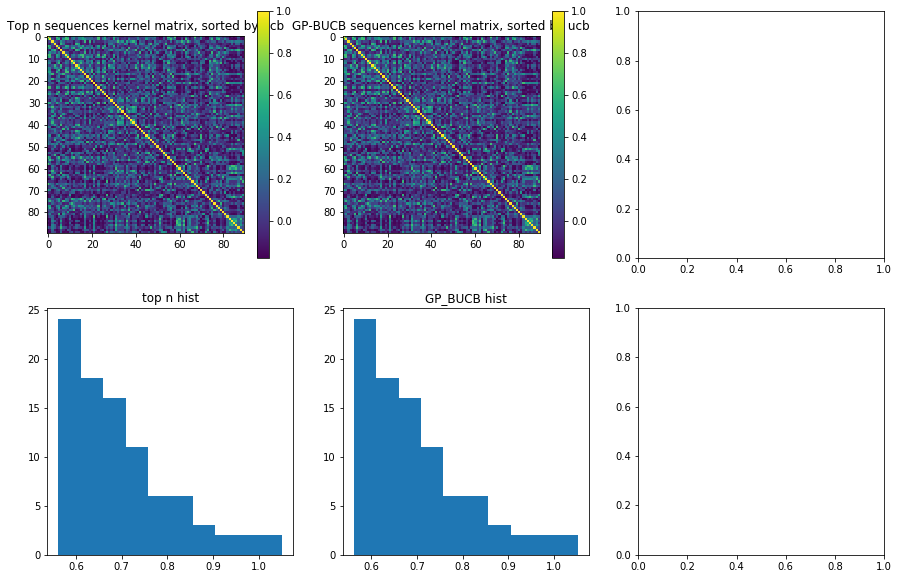

In [17]:
num_rows = 2
num_cols = 3

wd_kernel = WD_Shift_Kernel
fig,a = plt.subplots(num_rows, num_cols, figsize = (15,10))

wd_kernel.INIT_FLAG = False
im = a[0][0].imshow(top_n.gpr.wd_kernel_instance.__call__(np.asarray(top_n_rec_df['RBS'])), cmap = 'viridis')
fig.colorbar(im, ax =a[0][0])
a[0][0].set_title('Top n sequences kernel matrix, sorted by ucb')

wd_kernel.INIT_FLAG = False
im = a[0][1].imshow(gpbucb.gpr.wd_kernel_instance.__call__(np.asarray(gpbucb_rec_df['RBS'])), cmap = 'viridis')
fig.colorbar(im, ax =a[0][1])
a[0][1].set_title('GP-BUCB sequences kernel matrix, sorted by ucb')

# wd_kernel.INIT_FLAG = False
# all_features = np.concatenate((np.asarray(top_n_rec_df['RBS']), np.asarray(gpbucb_rec_df['RBS'])), axis = 0)
# im = a[0][2].imshow(wd_kernel(l=6, features = all_features).kernel_all_normalised, cmap = 'viridis')
# fig.colorbar(im, ax =a[0][2])
# a[0][2].set_title('Top n + GP-BUCB')

im = a[1][0].hist(top_n_rec_df['ucb'])
a[1][0].set_title('top n hist')

im = a[1][1].hist(gpbucb_rec_df['ucb'])
a[1][1].set_title('GP_BUCB hist')

# im = a[1][2].hist(gpbucb_rec_df['ucb'])
# a[1][2].set_title('GP_BUCB hist')

In [18]:
common_rec = set(top_n_rec_df['RBS']).intersection(set(gpbucb_rec_df['RBS']))
print('Number of intersection of recommendations: ', len(common_rec))

Number of intersection of recommendations:  90


In [19]:
para_name = 'alpha' + str(alpha) + '_beta' + str(beta) 
#+ 'kernelNorm' + str(kernel_norm_flag)

with pd.ExcelWriter('batch_ucb.xlsx', engine="openpyxl", mode='a') as writer:
    top_n_rec_df.to_excel(writer, sheet_name = 'top_n_core_' + para_name)
    gpbucb_rec_df.to_excel(writer, sheet_name = 'gpbucb_core_' + para_name)

In [23]:
# batch_ucb = pd.read_excel(open('batch_ucb.xlsx', 'rb'), sheet_name=None)
# batch_ucb_copy = pd.read_excel(open('batch_ucb_copy.xlsx', 'rb'), sheet_name=None)

# for key in batch_ucb.keys():
#     assert (batch_ucb[key]['RBS'] == batch_ucb_copy[key]['RBS']).all()